## 인코딩 방법 정리
### 원핫인코딩 (One-Hot Encoding)
- 원핫인코딩은 범주형 데이터를 수치형 데이터로 변환하는 방법입니다. 각 범주를 새로운 열로 나타내며, 해당 범주에 속하면 1, 속하지 않으면 0의 값을 가집니다.
```python
encoded_df = pd.get_dummies(df, columns=['CategoricalColumn'])
```
### 레이블인코딩 (Label Encoding)
레이블인코딩은 범주형 데이터를 순차적인 숫자로 변환하는 방법입니다. 주의해야 할 점은 숫자의 크기에 의미가 없는 경우에는 사용하지 않는 것이 좋습니다.
```python
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['CategoricalColumn'] = label_encoder.fit_transform(df['CategoricalColumn'])
```
### 순서인코딩 (Ordinal Encoding)
순서인코딩은 범주형 데이터를 순서를 고려하여 숫자로 변환하는 방법입니다. 범주 간의 순서가 중요한 경우에 사용됩니다.
```python
order_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['CategoricalColumn'] = df['CategoricalColumn'].map(order_mapping)
```
### 타겟인코딩 (Target Encoding)
타겟인코딩은 범주형 데이터를 해당 범주에 대한 타겟 변수의 평균 또는 다른 통계량으로 변환하는 방법입니다. 주로 회귀 문제에서 사용되며, 특정 범주의 타겟 변수 값을 대체하여 모델에 입력합니다.
```python
target_mapping = df.groupby('CategoricalColumn')['TargetColumn'].mean().to_dict()
df['CategoricalColumn'] = df['CategoricalColumn'].map(target_mapping)
```

## 데이터 클리닝
### 1. 결측치 처리
- `df.isnull().sum()` # 결측치 개수 확인
- `df.dropna()` # 결측치가 있는 행 제거
- `df.fillna(0)` # 결측치를 0으로 대체
- `df.fillna(df['Age'].mean(), inplace=True)` # 결측치를 평균값으로 대체
- `df.fillna(df['Age'].median(), inplace=True)` # 결측치를 중앙값으로 대체
- `df.fillna(df['Age'].mode()[0], inplace=True)` # 결측치를 최빈값으로 대체
- `df['Age'].fillna(method='ffill', inplace=True)` # 결측치를 앞의 값으로 대체
- `df['Age'].fillna(method='bfill', inplace=True)` # 결측치를 뒤의 값으로 대체
- `df.interpolate(method='linear', inplace=True)` # 결측치를 선형으로 대체, 시계열 데이터에 적합
- `df.interpolate(method='polynomial', order=2, inplace=True)` # 결측치를 2차 함수로 대체, 시계열 데이터에 적합
- `df.interpolate(method='spline', order=2, inplace=True)` # 결측치를 2차 스플라인으로 대체, 시계열 데이터에 적합
- `df.interpolate(method='krogh', inplace=True)` # 결측치를 Krogh 방법으로 대체, 시계열 데이터에 적합(Krogh는 곡선을 생성하지만 고차원 다항식을 생성하지 않아 과적합을 방지할 수 있음)
- `df.interpolate(method='piecewise_polynomial', order=2, inplace=True)` # 결측치를 2차 다항식으로 대체, 시계열 데이터에 적합
### 다중 대치법
```python
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=10, random_state=0, initial_strategy='median', tol=0.001, n_nearest_features=4)
# initial_strategy: 결측치를 대체할 초기값을 설정합니다. 'mean', 'median', 'most_frequent' 중 하나를 선택할 수 있습니다.
# tol: 결측치 대체가 수렴하는 기준을 설정합니다.
# n_nearest_features: 결측치 대체에 사용할 특성의 개수를 설정합니다. (default=None: 모든 특성 사용)
imputed_df = pd.DataFrame(imputer.fit_transform(df))
```

### 2. 이상치 처리
#### IQR(Interquartile Range, 사분범위) 기반 이상치 처리
- `df.describe()` # 기술통계량 확인
- `sns.boxplot(x=df['Column'], y=df['TargetColumn'])` # 상자그림으로 이상치 확인
- `Q1 = df['Column'].quantile(0.25)` # 1사분위수
- `Q3 = df['Column'].quantile(0.75)` # 3사분위수
- `IQR = Q3 - Q1` # IQR(Interquartile Range, 사분범위)
- `lower_bound = Q1 - 1.5 * IQR` # 하한값
- `upper_bound = Q3 + 1.5 * IQR` # 상한값
- `df = df[(df['Column'] >= lower_bound) & (df['Column'] <= upper_bound)]` # 이상치 제거
#### Z-Score 기반 이상치 처리
- `from scipy import stats`
- `z_scores = np.abs(stats.zscore(df['Column']))` # Z-Score 계산
- `threshold = 3` # 임계값 설정
- `df = df[(z_scores < threshold)]` # 이상치 제거
#### DBSCAN 기반 이상치 처리
- `from sklearn.cluster import DBSCAN`
- `outlier_detection = DBSCAN(min_samples=2, eps=3)` # eps: 이웃을 정의하는 거리, min_samples: 핵심 샘플의 최소 개수
- `clusters = outlier_detection.fit_predict(df)` # 이상치를 제외한 모든 샘플의 클러스터 레이블을 반환
- `df = df[clusters != -1]` # 이상치 제거
#### Isolation Forest 기반 이상치 처리
- `from sklearn.ensemble import IsolationForest`
- `outlier_detection = IsolationForest(contamination=0.01)` # contamination: 이상치 비율
- `clusters = outlier_detection.fit_predict(df)` # 이상치를 제외한 모든 샘플의 클러스터 레이블을 반환
- `df = df[clusters != -1]` # 이상치 제거
#### Local Outlier Factor 기반 이상치 처리
- `from sklearn.neighbors import LocalOutlierFactor`
- `outlier_detection = LocalOutlierFactor(n_neighbors=2, contamination=0.01)` # n_neighbors: 이웃의 개수, contamination: 이상치 비율
- `clusters = outlier_detection.fit_predict(df)` # 이상치를 제외한 모든 샘플의 클러스터 레이블을 반환
- `df = df[clusters != -1]` # 이상치 제거

### 3. 중복 데이터 처리
- `df.duplicated().sum()` # 중복 데이터 개수 확인
- `df.drop_duplicates(inplace=True)` # 중복 데이터 제거

### 4. 특성 공학
- `df['NewColumn'] = df['Column1'] +-*/ df['Column2']` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'] ** df['Column2']` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'] % df['Column2']` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'].apply(lambda x: x**2)` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'].apply(lambda x: x**0.5)` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'].apply(lambda x: np.log(x))` # 새로운 특성 생성
- `df['NewColumn'] = df['Column1'].apply(lambda x: np.exp(x))` # 새로운 특성 생성

### 5. 특성 선택
#### 상관관계 기반 특성 선택
- `df.corr()` # 상관관계 확인

In [1]:
import pandas as pd
train=pd.read_csv('train.csv')

<Axes: ylabel='SalePrice'>

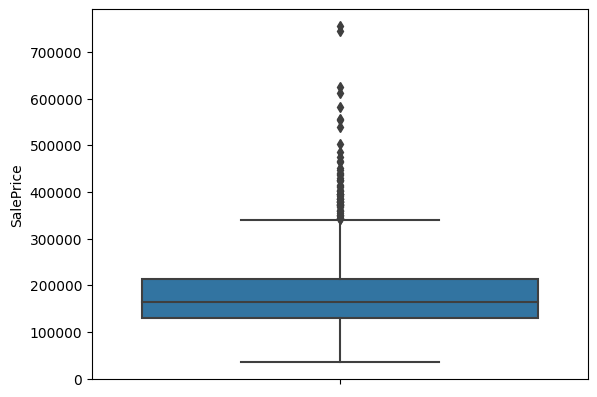

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(y=train['SalePrice'])